In [1]:
using Pkg
Pkg.activate("..")

  Activating environment at `E:\Projects\OCDNN.jl\Project.toml`


In [2]:
using Revise
using PyPlot, OCDNN, Printf, Random, Serialization

In [3]:
function in_dir(f, path::String)
    current = pwd()
    cd(path)
    f()
    cd(current)
end

in_dir (generic function with 1 method)

In [93]:
f(x) = 2x + sin(2x) + 3

f (generic function with 1 method)

In [194]:
Random.seed!(123)
xs = 0:0.02:5
ys = f.(xs) + randn(length(xs));

In [195]:
N = length(xs)

251

In [196]:
dataset = reshape(collect(xs),length(xs),1), ys;

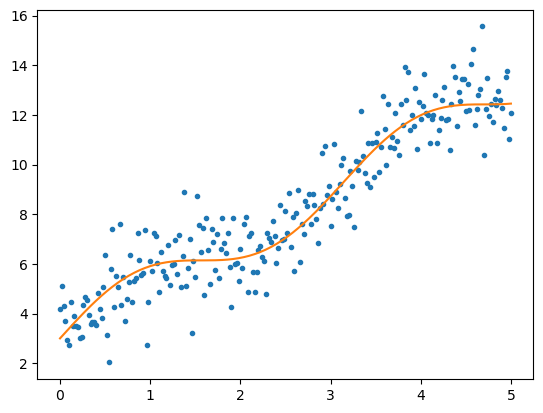

In [197]:
plot(xs, ys, ".")
plot(xs, f.(xs) );

In [166]:
nlayers = 2
channels = 5 # number of neurons per layer
niter = 50_000
τ=0.01;
τ_max=0.2;
stepsize = 0.1;

In [167]:
A_eu = reshape([0],(1,1));
w_eu = [1];
A_ie = [0 0; 1 0];
w_ie = [0.5 ;0.5];
A_kutta4 = [0 0 0 0;0.5 0 0 0;0 0.5 0 0;0 0 1 0];
w_kutta4 = 1/6*[1;2;2;1];
A_kutta3 = [0 0 0;1/2 0 0;-1 2 0];
w_kutta3 = [1/6;2/3;1/6];

In [168]:
rk4 = OCDNN.ExplicitRungeKutta(A_kutta4,w_kutta4,"RK4");
rk3 = OCDNN.ExplicitRungeKutta(A_kutta3,w_kutta3,"RK3");
rk2 = OCDNN.ExplicitRungeKutta(A_ie,w_ie,"RK2");
euler = OCDNN.ExplicitRungeKutta(A_eu,w_eu,"Euler");
rks = [euler,rk2,rk3,rk4];
names = [rk.name for rk in rks];

In [169]:
eta = x -> exp(x)/(exp(x)+1)
eta = x -> x

#113 (generic function with 1 method)

In [170]:
problem = OCDNN.Problem(tanh, eta, ys);

In [171]:
function cb(iter, rkmethod, nlayers, α, log, Ctrls)
    period = 10_000
    if rem(iter,period) == 0 || iter == 1
        @printf("\nMethod=%s, nlayers=%d\n",rkmethod.name,nlayers)
        @printf("Iteration no: %d\n",iter)
        @printf("Value of alpha: %7.4f\n",α);
        @printf("Residual: %8.4f\n",log.loss[end])
        @printf("Norm Grad: %8.4e\n",log.grad_norm[end]);
        if iter > 1
            @printf("Time: %8.4f\n",sum(log.time[end-period+1:end]));
        end
    end
end

cb (generic function with 1 method)

In [172]:
xs, feat = dataset;

In [139]:
all_results = [train_ode_dnn(dataset, nlayers, channels, rk, niter, τ, τ_max, stepsize, problem, cb) for rk in rks];


Method=Euler, nlayers=2
Iteration no: 1
Value of alpha:  0.0003
Residual: 395.0308
Norm Grad: 2.1177e+03

Method=Euler, nlayers=2
Iteration no: 10000
Value of alpha:  0.0006
Residual: 141.3661
Norm Grad: 1.6561e+00
Time:   5.5768

Method=Euler, nlayers=2
Iteration no: 20000
Value of alpha:  0.0006
Residual: 135.5935
Norm Grad: 9.6020e-01
Time:   5.3658

Method=Euler, nlayers=2
Iteration no: 30000
Value of alpha:  0.0013
Residual: 133.9196
Norm Grad: 2.6711e-01
Time:   5.4233

Method=Euler, nlayers=2
Iteration no: 40000
Value of alpha:  0.0013
Residual: 133.4621
Norm Grad: 4.0730e-01
Time:   5.5712

Method=Euler, nlayers=2
Iteration no: 50000
Value of alpha:  0.0013
Residual: 131.1396
Norm Grad: 4.3419e-01
Time:   5.4751

Method=RK2, nlayers=2
Iteration no: 1
Value of alpha:  0.0003
Residual: 871.0410
Norm Grad: 7.8589e+03

Method=RK2, nlayers=2
Iteration no: 10000
Value of alpha:  0.0006
Residual: 151.2986
Norm Grad: 5.5317e-01
Time:  10.9059

Method=RK2, nlayers=2
Iteration no: 20000

In [140]:
final_string = string(nlayers)*"_layers_"*string(N)*"_points_"*string(niter)*"_iter_"*string(channels)*"_channels"
traineddir = "..\\train\\Non_Linear_Regression\\"*final_string*".tmp"
serialize(traineddir, all_results)

In [177]:
final_string = string(nlayers)*"_layers_"*string(N)*"_points_"*string(niter)*"_iter_"*string(channels)*"_channels"
outputdir = "..\\images\\Non_Linear_Regression\\"*final_string
if !isdir(outputdir)
    mkdir(outputdir)
end

In [178]:
all_Ctrls,all_logs = first.(all_results),last.(all_results);

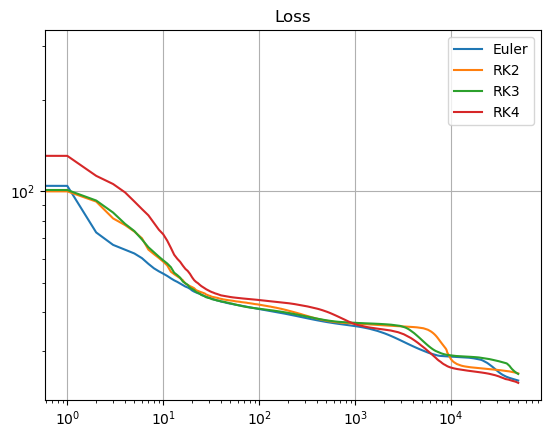

PyObject <matplotlib.legend.Legend object at 0x00000000011C3D60>

In [179]:
fig, axs = PyPlot.subplots()
axs.set_title("Loss")
for i in 1:4
    axs.loglog(all_logs[i].loss, label = names[i])
end
grid()
legend()

In [180]:
in_dir(outputdir) do
    fig.savefig("loss_rks_"*final_string*".pdf")
end

In [181]:
all_times = [sum(all_logs[i].time) for i in 1:4];

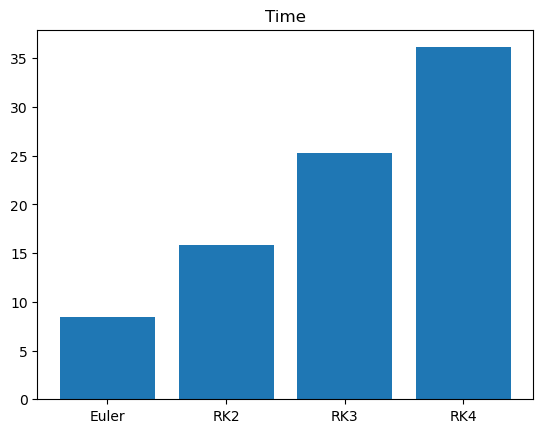

In [182]:
fig, ax = PyPlot.subplots()
ax.set_title("Time")
ax.bar(1:4,height=all_times)
ax.set_xticks(1:4)
ax.set_xticklabels(names);

In [183]:
in_dir(outputdir) do
    fig.savefig("time_rks_"*final_string*".pdf")
end

In [184]:
all_Ctrls_test = deepcopy.(all_Ctrls);

In [185]:
xs1 = collect(0:0.01:5);

In [186]:
Y0_test = [[x] for x in xs1];

In [187]:
for i in 1:4
    all_Ctrls_test[i].Y0 = hcat(Y0_test...)';
end

In [188]:
classifieds = [[] for i in 1:4]
for i in 1:4
    classifieds[i] = OCDNN.RKforwardstepper(all_Ctrls_test[i],rks[i],problem).Classifier;
end

In [189]:
# Linear Regression
β1 = sum((xs.-1/length(xs)*sum(xs)).*ys)/sum((xs.-1/length(xs)*sum(xs)).^2)
β0 = 1/length(ys)*sum(ys).-β1.*1/length(xs)*sum(xs);

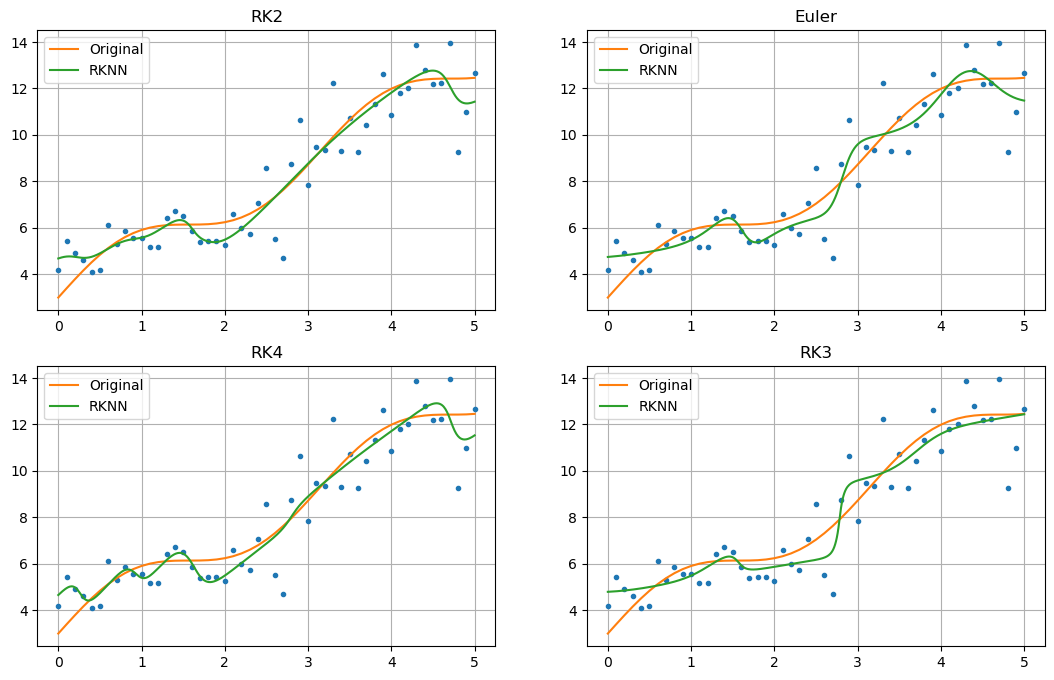

In [190]:
fig, axs = PyPlot.subplots(2,2,figsize=(13,8))
for i in 1:4
    m,n = Int64(floor((i+1)/2)),(i%2)+1
    axs[m,n].set_title(names[i])
    axs[m,n].plot(xs, ys, ".")
    axs[m,n].plot(xs, f.(xs) , label="Original");
    #axs[m,n].plot(xs, β1 .*xs .+ β0, label="Linear Reg");
    axs[m,n].plot(xs1, classifieds[i], label="RKNN")
    axs[m,n].grid()
    axs[m,n].legend()
end

In [191]:
in_dir(outputdir) do
    fig.savefig("Linear_Reg_rks_subplots"*final_string*".pdf")
end

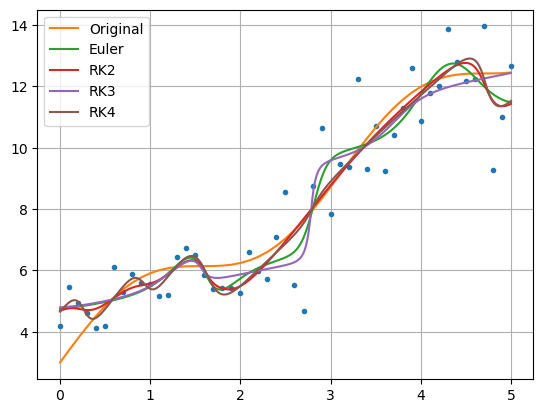

PyObject <matplotlib.legend.Legend object at 0x0000000001027040>

In [192]:
fig, ax = PyPlot.subplots()
ax.plot(xs, ys, ".")
ax.plot(xs, f.(xs) , label="Original");
#ax.plot(xs, β1 .*xs .+ β0, label="Linear Reg");
for i in 1:4
    ax.plot(xs1, classifieds[i], label=names[i])
end
ax.grid()
ax.legend()

In [193]:
in_dir(outputdir) do
    fig.savefig("Linear_Reg_rks_plots"*final_string*".pdf")
end